In [2]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

img_height = 300
img_width = 300

K.clear_session() 

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], 
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

#학습된 weight의 경로를 지정
weights_path = 'ssd300_pascal_07+12_epoch-04_loss-3.0387_val_loss-3.5244_weight.h5'

model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
#영상의 경로를 지정하고 프레임 캡쳐
vidcap = cv2.VideoCapture('C:\\Users\\user\Desktop\\video.mp4')
success,imagefile = vidcap.read()
count = 0
while success:
    if(count%5==0):
#프레임 캡쳐를 저장할 경로
        cv2.imwrite("C:\\Users\\user\Desktop\\frames\\frame%d.jpg" % count, imagefile)    
    success,imagefile = vidcap.read()
    count += 1

orig_images = [] 
input_images = [] 

for i in range(0,320):
    if(i%5==0):
#프레임 캡쳐를 저장하는 경로
        img_path = 'C:\\Users\\user\Desktop\\frames\\frame%d.jpg'%i
        #print(img_path)
        orig_images.append(imread(img_path))
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img = image.img_to_array(img)
        img = np.array(img)
        input_images.append(img)
        
input_images = np.array(input_images)

num_of_frames = 16
counting = 0

print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
    
for i in range(0, int(len(input_images)/num_of_frames)):
    y_pred = model.predict(input_images[i*num_of_frames:i*num_of_frames + num_of_frames])
    confidence_threshold = 0.4

    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
    np.set_printoptions(precision=2, suppress=True, linewidth=90)

    for j in range(0, num_of_frames):
        print('frame :',counting)
        counting += 5
#        print(y_pred_thresh[j])
        for box in y_pred_thresh[j]:
            # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
            xmin = box[2] * orig_images[0].shape[1] / img_width
            ymin = box[3] * orig_images[0].shape[0] / img_height
            xmax = box[4] * orig_images[0].shape[1] / img_width
            ymax = box[5] * orig_images[0].shape[0] / img_height
            print('xmin : ',xmin, '  ymin : ',ymin, '  xmax : ',xmax, '  ymax : ',ymax)
            
'''
1. 여기서 리포트 된 픽셀정보를 바탕으로 각 frame들을 Crop
2. 각 cropped image들에 대해 sauvola, skeletonize, canny edge 적용
3. (여기서부터 핵심) skeleton line상의 각 픽셀들에 어떻게 접근할 것인가?
4. 각 픽셀들에 접근했다면, 몇 픽셀 간격으로 이동할 것이며, 몇 픽셀 떨어진 픽셀을 방향 설정의 기준으로 잡을 것인가?
5. 방향 설정까지 했다면, 그 방향에서 edge가 몇 픽셀 떨어져 있는지를 재고, 각 skeleton line상의 pixel에 그 정보를 저장하자!
6. 거기서 max값을 return하자
'''

c:\users\user\anaconda2\envs\tensorflow-gpu\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


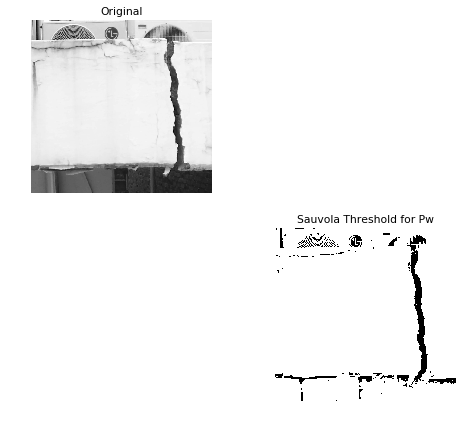

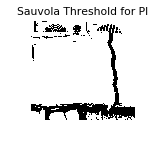

In [19]:
# 1. Image binarization(Sauvola's method) using Pw and Pl, respectively

import matplotlib
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage import data
from skimage.color import rgb2gray
from skimage.data import page
from skimage.filters import (threshold_sauvola)
from PIL import Image

matplotlib.rcParams['font.size'] = 9

# Upload the image
img = cv2.imread("../../Desktop/frame320.jpg")

# Convert the image from RGB to grayscale
img_gray = rgb2gray(img)

# 논문에선 각각 70,180이었으나 여기선 홀수 input만 가능
window_size_Pw = 71
window_size_Pl = 181
thresh_sauvola_Pw = threshold_sauvola(img_gray, window_size=window_size_Pw, k=0.42)
thresh_sauvola_Pl = threshold_sauvola(img_gray, window_size=window_size_Pl, k=0.18)

#Below are the converted images through Sauvola's method.
# _bw will contain 0 or 1, not true or false. bw means black or white.
binary_sauvola_Pw = img_gray > thresh_sauvola_Pw
binary_sauvola_Pl = img_gray > thresh_sauvola_Pl
binary_sauvola_Pw_bw = img_gray > thresh_sauvola_Pw
binary_sauvola_Pl_bw = img_gray > thresh_sauvola_Pl

binary_sauvola_Pw_bw.dtype = 'uint8'
binary_sauvola_Pl_bw.dtype = 'uint8'

binary_sauvola_Pw_bw *= 255
binary_sauvola_Pl_bw *= 255

io.imsave('../../Desktop/Sauvola_Pw.jpg', binary_sauvola_Pw_bw)
io.imsave('../../Desktop/Sauvola_Pl.jpg', binary_sauvola_Pl_bw)

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(img_gray, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola_Pw_bw, cmap=plt.cm.gray)
plt.title('Sauvola Threshold for Pw')
plt.axis('off')

plt.show()

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola_Pl_bw, cmap=plt.cm.gray)
plt.title('Sauvola Threshold for Pl')
plt.axis('off')

plt.show()

In [20]:
print(type(binary_sauvola_Pw))
print(binary_sauvola_Pw)

<class 'numpy.ndarray'>
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


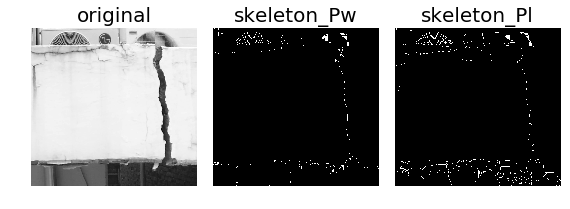

In [21]:
# 2. Extract the skeletons of each images

from skimage.morphology import skeletonize
from skimage.util import invert

# Invert the binarized images
img_Pw = invert(binary_sauvola_Pw)
img_Pl = invert(binary_sauvola_Pl)

# Below are skeletonized images
skeleton_Pw = skeletonize(img_Pw)
skeleton_Pl = skeletonize(img_Pl)

# Convert true/false to 1/0 to save it as image
skeleton_Pw.dtype = 'uint8'
skeleton_Pl.dtype = 'uint8'

skeleton_Pw *= 255
skeleton_Pl *= 255

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(img_gray, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton_Pw, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton_Pw', fontsize=20)

io.imsave("../../Desktop/skeleton_Pw.jpg", skeleton_Pw)

ax[2].imshow(skeleton_Pl, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('skeleton_Pl', fontsize=20)

io.imsave("../../Desktop/skeleton_Pl.jpg", skeleton_Pl)

fig.tight_layout()
plt.show()

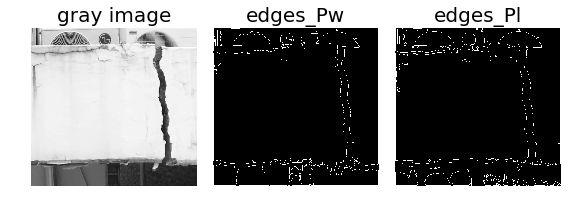

In [30]:
# 3. Detect the edges of each images
### edge detection 할 때, 좋은 parameter를 찾아야 한다. 지금은 edge가 너무 두꺼움 (overestimation됨) ###
import numpy as np
from scipy import ndimage as ndi
from skimage import feature

# Compute the Canny filter for two values of sigma
# canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)
# sigma가 1이었으나, 0.1로 조정하여 실제 균열 edge와 거의 같게 만듦.
# 정확도에서 문제가 생긴다면 1. skeleton의 방향 설정 방법을 바꾸던가, 2. 여기서 시그마 값을 살짝 늘리거나 줄여가면서 정확도를 테스트 해볼 것
edges_Pw = feature.canny(binary_sauvola_Pw, 0.4)
edges_Pl = feature.canny(binary_sauvola_Pl, 0.4)

edges_Pw.dtype = 'uint8'
edges_Pl.dtype = 'uint8'

edges_Pw *= 255
edges_Pl *= 255

io.imsave("../../Desktop/edges_Pw.jpg", edges_Pw)
io.imsave("../../Desktop/edges_Pl.jpg", edges_Pl)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(img_gray, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('gray image', fontsize=20)

ax2.imshow(edges_Pw, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('edges_Pw', fontsize=20)

ax3.imshow(edges_Pl, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('edges_Pl', fontsize=20)

fig.tight_layout()

plt.show()

In [ ]:
'''
1. 어떻게 skeletion의 direction을 추출할 것인가 -> 가장 정확한 방법을 찾아야 함 -> 잘못 세면 overestimation 되기 십상
2. direction만 잘 잡는다면 width를 계산하는 것은 오히려 어렵지 않다
3. skeleton을 추출한 이미지와 edge를 추출한 이미지에 함께 접근해가며 픽셀마다 width를 매기면 됨
4. 여기서 수 많은 width들 중 최종 width는 어떻게 정할 것인지가 또 다른 문제가 됨
'''